In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from numpy import inf
from scipy.stats import moment

target_rank = 'gold players'
df_raw = pd.read_csv('gold_player.csv', index_col=0)

# add ratio features
winRate = df_raw['total_wins']/df_raw['total_rounds_played']
winRate[winRate == inf] = 0
KD = df_raw['total_kills']/df_raw['total_deaths']
KD[KD == inf] = 0
HDK = df_raw['total_kills_headshot']/df_raw['total_kills']
HDK[HDK == inf] = 0

df = pd.DataFrame(np.stack([winRate, KD, HDK], axis = 1), index=df_raw.index, columns=['win-rate', 'kill-death', 'headshot-kill'])
df = pd.concat([df, df_raw],axis = 1)

print(df.shape)
# remove obvious outliers:
df = df[ (df['win-rate']<=1) & \
        ( df['headshot-kill']<=1) &\
        (df['total_shots_fired']>df['total_kills']) &\
        (df['total_kills']/9 <= df['total_rounds_played'])]
print(df.shape)

df_clean = df

(18978, 14)
(18674, 14)


# Correlation

## pearson

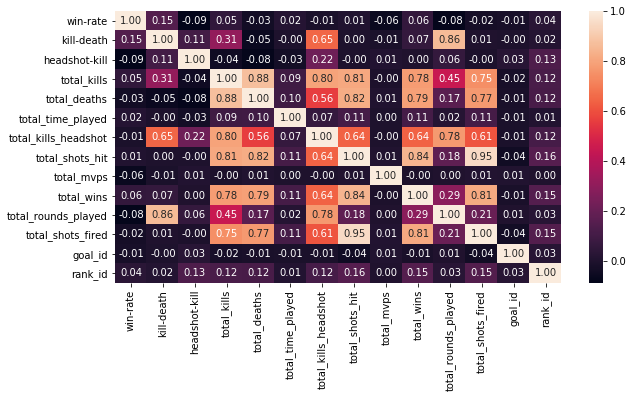

In [2]:
df_corr = df.corr('pearson')

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")
plt.savefig('{}_pearson.png'.format(target_rank))
plt.show()

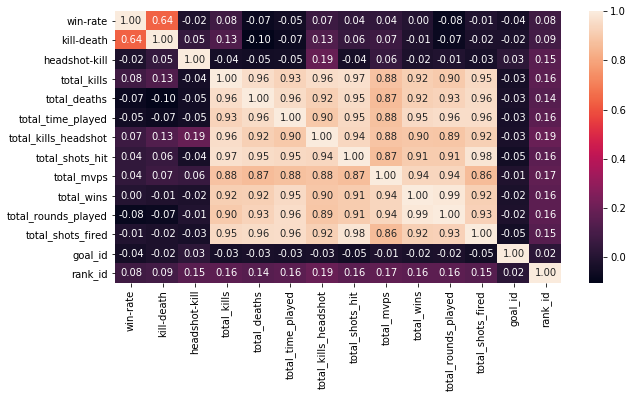

In [3]:
df_corr = df.corr('spearman')

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")
plt.savefig('{}_spearman.png'.format(target_rank))
plt.show()

# K-means

In [10]:
def df_clustering( n_clusters_, colors, df, plot = True):
    kmeans = KMeans(n_clusters=n_clusters_).fit(df[['win-rate', 'kill-death', 'headshot-kill']])
    labels = kmeans.labels_

    c_list = [colors[labels[i]] for i in range(df.shape[0])]

    center = kmeans.cluster_centers_

    x,y,z = df['win-rate'].values,df['kill-death'].values,df['headshot-kill'].values
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 2]

    if plot:
        plt.figure(figsize=(9, 6))
        ax1 = plt.subplot(111,projection='3d')
        
        ax1.scatter(x, y, z, s=15, color=c_list, alpha=0.5)
        ax1.scatter(x_c, y_c, z_c, s=120, alpha=0.8, c='black')
        ax1.set_title('Raw Data of rank=18 players Built by KMeans')
        ax1.set_xlabel('win-rate')
        ax1.set_ylabel('kill/death')
        ax1.set_zlabel('headshot/kill')
    
    return [labels, x_c,y_c,z_c]

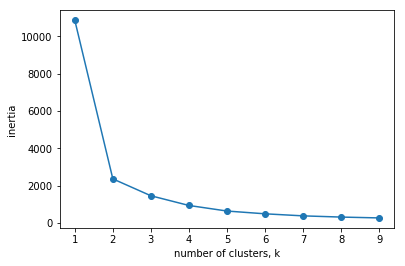

In [17]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_clean[['win-rate', 'kill-death', 'headshot-kill']])  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

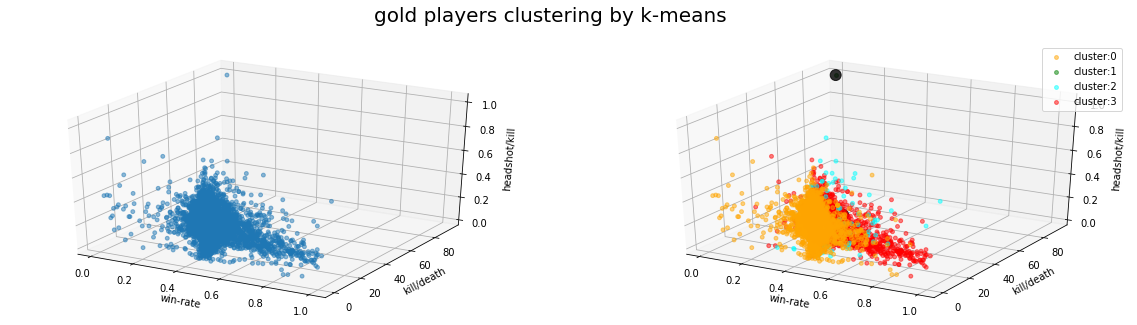

In [18]:
def plot_n_cluster(n_clusters, df):
    plt.figure(figsize=(20, 5))

    ax2 = plt.subplot(121,projection='3d')

    c = df
    x,y,z = c['win-rate'].values, c['kill-death'].values, c['headshot-kill'].values
    ax2.scatter(x, y, z, s=15, alpha=0.5)

    ax2.set_xlabel('win-rate')
    ax2.set_ylabel('kill/death')
    ax2.set_zlabel('headshot/kill')


    colors = ['orange','green','cyan','red','blue','pink','gray','brown']
    df_labeled, x_c, y_c, z_c = df_clustering(n_clusters, colors, df, plot = False)

    df['label'] = df_labeled


    ax1 = plt.subplot(122,projection='3d')

    for i in range(n_clusters):
        c = df[df.label == i]
        x,y,z = c['win-rate'].values, c['kill-death'].values, c['headshot-kill'].values
        ax1.scatter(x, y, z, s=15, color=colors[i], alpha=0.5, label='cluster:{}'.format(i))

    ax1.scatter(x_c, y_c, z_c, s=120, alpha=0.8, c='black')
    # ax1.set_title('{} clustered by k-means'.format(target_rank))
    ax1.set_xlabel('win-rate')
    ax1.set_ylabel('kill/death')
    ax1.set_zlabel('headshot/kill')
    plt.legend()

    plt.suptitle('{} clustering by k-means'.format(target_rank), fontsize = 20)

    plt.savefig('{} clustering by k-means'.format(target_rank))
    

plot_n_cluster(4, df_clean)

In [7]:
# analyze outlier and 

# analyze feature distribution

In [8]:
def analyze_feat_dist( data ):
    m = round(max(data), 1)
    avg = round(np.mean(data),1)
    skew = moment(data, 3)/(np.std(data))**3
    kurt = moment(data, 4)/(np.std(data))**4    
    return m,avg,skew,kurt

In [9]:
label_index_dict = {}
label_index_dict[0] = [i for i in range(len(df_labeled)) if df_labeled[i]==0]
label_index_dict[1] = [i for i in range(len(df_labeled)) if df_labeled[i]==1]
label_index_dict[2] = [i for i in range(len(df_labeled)) if df_labeled[i]==2]
label_index_dict[3] = [i for i in range(len(df_labeled)) if df_labeled[i]==3]

label_df_dict = {}
label_df_dict[0] = df_clean.iloc[label_index_dict[0]]
label_df_dict[1] = df_clean.iloc[label_index_dict[1]]
label_df_dict[2] = df_clean.iloc[label_index_dict[2]]
label_df_dict[3] = df_clean.iloc[label_index_dict[3]]

plt.figure()

def analyze_feature_of_cluster(cluster, feat):
    if feat == 'total_time_played':
        data = label_df_dict[cluster].total_time_played.values/3600
    
    elif feat == 'avg_kill_per_round':
        data = label_df_dict[cluster]['total_kills']/label_df_dict[cluster]['total_rounds_played']

    elif feat == 'headshot_per_round':
        data = label_df_dict[cluster]['total_kills_headshot']/label_df_dict[cluster]['total_rounds_played']
        
    elif feat == 'headshot-kill':
        data = label_df_dict[cluster]['headshot-kill']        
    
    m,avg,skew,kurt = analyze_feat_dist(data) 
    plt.hist(data, normed=True)
    plt.xlabel(feat)
    plt.ylabel('number of people')
    plt.title('cluster {}'.format(cluster))
    print('cluster {}:max = {}\taverage={}\tskew={}\tkurt={}'.format(cluster, m, avg, round(skew,1), round(kurt,1)))

plt.subplot(2,2,1)
feat = 'total_time_played'
analyze_feature_of_cluster(0,feat )

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))


plt.show()

NameError: name 'df_labeled' is not defined

In [ ]:
plt.figure()
plt.subplot(2,2,1)
feat = 'avg_kill_per_round'
analyze_feature_of_cluster(0,feat)

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))


plt.show()


In [ ]:
plt.figure()
plt.subplot(2,2,1)
feat = 'headshot_per_round'
analyze_feature_of_cluster(0,feat)

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))

plt.show()

In [ ]:
plt.figure()
plt.subplot(2,2,1)
feat = 'headshot-kill'
analyze_feature_of_cluster(0,feat)

plt.subplot(2,2,2)
analyze_feature_of_cluster(1,feat)

# plt.subplot(2,2,3)
# analyze_feature_of_cluster(2,feat)

# plt.subplot(2,2,4)
# analyze_feature_of_cluster(3,feat)

plt.tight_layout()
plt.savefig('{}_{}.png'.format(target_rank, feat))


plt.show()